Spectral clustering of graphs
=============================

**Author:** Jean-Gabriel Young
**Date:** July 13, 2016

Notebook accompanying my presentation at the 2016 CRM Summer School on spectral theory.


The notebook starts with a number of imports and boilerplate code for visualization.
This can be safely skipped.

# Import and visualization functions

In [1]:
# Modules cell
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re
import scipy as sp
import scipy.linalg
import scipy.stats as sps
import networkx as nx
import copy
%matplotlib inline
sns.set_style('ticks')

In [2]:
two_colors_palette = ["#3182bd", "#f03b20"]
def get_two_colors(n):
    return [two_colors_palette[0]] * (n//2) + [two_colors_palette[1]] * (n//2)

In [3]:
def visualize_graph(g, colors=None, pos=None, figsize=None):
    if pos is None:
        pos = nx.spring_layout(g, iterations=1000)

    # Create position copies for shadows, and shift shadows
    pos_shadow = copy.deepcopy(pos)
    shift_amount = 0.006
    for idx in pos_shadow:
        pos_shadow[idx][0] += shift_amount
        pos_shadow[idx][1] -= shift_amount

    #~~~~~~~~~~~~
    # Draw graph
    #~~~~~~~~~~~~
    if figsize is None:
        fig = plt.figure(frameon=False)
    else:
        fig = plt.figure(frameon=False, figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    if colors is None:
        colors = ["#3182bd"] * g.number_of_nodes()
    nx.draw_networkx_nodes(g, pos_shadow, node_color='k', alpha=0.5)
    nx.draw_networkx_nodes(g, pos, node_color=colors, linewidths=1)
    nx.draw_networkx_edges(g, pos, width=1)


In [4]:
def visualize_spectrum_density(spectrum, nbins=10):
    sns.distplot(np.real(spectrum), bins=nbins, norm_hist=False, axlabel='$\lambda$')

In [5]:
def visualize_sparse_mat(spmat):
    plt.imshow(spmat.todense(), interpolation='nearest', origin='upper')

In [6]:
def visualize_mat(mat):
    plt.imshow(mat, interpolation='nearest', origin='upper')

In [7]:
def visualize_eigenvector(eigvec, colors=None):
    if colors is None:
        colors = ["#3182bd"  if i < 0 else "#f03b20" for i in eigvec]
    plt.scatter(range(1,len(eigvec)+1), eigvec, c=colors)
    plt.xlim(0,len(eigvec)+1)
    plt.xlabel('$i$')
    plt.ylabel('$x_i$')

In [8]:
def get_kth_eigenvector_sparse(g, matrix=nx.linalg.adjacency_matrix, k=2, nodelist=None, which='LM'):
    return np.real(sp.sparse.linalg.eigs(matrix(g, nodelist=nodelist).astype(np.float), k=k, which=which)[1][:,1])

In [9]:
def get_kth_eigenvector(g, matrix=nx.linalg.adjacency_matrix, k=2, nodelist=None):
    l,x = np.linalg.eig(matrix(g, nodelist=nodelist).todense())
    idx = l.argsort() 
    l = l[idx]
    x = x[:,idx]
    return np.real(x[:,k])

# The Barbell graph

We will first build our intuition for spectral clustering on very simple graphs.

Our graph of choice will be the so-called barbell graph---it consists of two cliques connected by a path.
It has clear clusters corresponding to the cliques at the end of the barbell.
Any decent clustering method *will have* to be able to split the barbell in two blocks corresponding to the cliques.

We will use the [`networkx`](https://networkx.github.io/) module (here aliased with the shorter `nx`) to handle graphs.
It's written in pure python and it is easy to use.
It comes with an impressive number of out of the box functions.

In particular, the submodule `generators` contains many of the classic graphs analyzed in graph theory.

In [10]:
barbell = nx.generators.barbell_graph(10,0)

Below, we just visualize the graph 

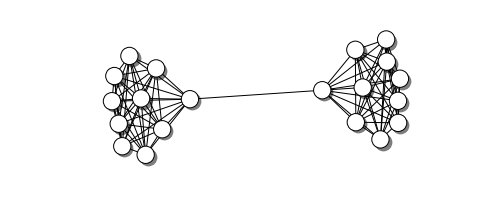

In [11]:
# Obtain a clean layout (can be skipped)
pos_barbell = nx.layout.fruchterman_reingold_layout(barbell,scale=0.8,pos=nx.spectral_layout(barbell))
# Visualize the graph directly in the notebook
visualize_graph(barbell, pos=pos_barbell, colors=['w']*20, figsize=(6,2.5))

# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_10_0.pdf',  bbox_inches = 'tight', pad_inches=0)

We will also investigate a variation of the the barbell graph.
We build it so that there exists unwanted optima in our quality functions.

In [12]:
barbell_mod =  barbell.copy()
barbell_mod.add_edge(5,20)
barbell_mod.add_edge(15,21)

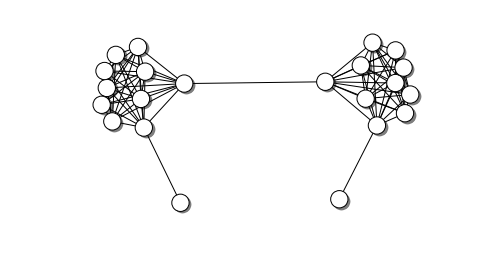

In [13]:
# Visualize the graph directly in the notebook
pos_barbell_mod = nx.layout.fruchterman_reingold_layout(barbell_mod, pos=nx.spectral_layout(barbell))
visualize_graph(barbell_mod, pos=pos_barbell_mod, colors=["w"]*22, figsize=(6,3))
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_mod.pdf',  bbox_inches = 'tight', pad_inches=0)

As explained in the lecture notes, the eigenvectors of the Laplacian matrix of the graph can be used to find an approximate bisection of this graph.

We will first look at the density $\rho[\lambda(\mathbf{L})]$ of the spectrum of the Laplacian matrix of the this modified Barbell graph.
The `linalg` submodules of `networkx` provides these facilities right out of the box.

In [14]:
barbell_mod_spectrum = nx.linalg.laplacian_spectrum(barbell_mod)

(0, 15)

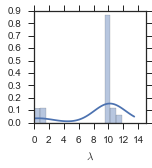

In [15]:
plt.figure(figsize=(2,2))
visualize_spectrum_density(barbell_mod_spectrum, nbins=15)
plt.xlim(0,15)
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_mod_laplacian_spectrum.pdf',  bbox_inches = 'tight', pad_inches=0)

There is a 0 eigenvalue---it is always associated to a uniform eigenvector since the rows and columns of $\mathbf{L}$ sum to 0.
We expect this eigenvector to fail the  balancing condition since the sum of its element will be proportional to $N$.


We will therefore look at the second eigenvector straightaway.

In [16]:
barbell_mod_x = get_kth_eigenvector(barbell_mod, matrix=nx.linalg.laplacian_matrix, k=1)

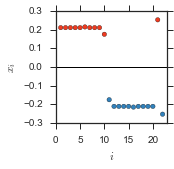

In [17]:
plt.figure(figsize=(2,2))
visualize_eigenvector(np.array(barbell_mod_x), colors=None)
plt.plot([0,23],[0,0], c='k', lw=1)
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_mod_laplacian_eigenvector.pdf',  bbox_inches = 'tight', pad_inches=0)

In a general clustering scenario, we would cluster these values with, e.g. K-Means, in $\mathbb{R}^g$.
Strictly speaking, what we have here is a distribution of points in $\mathbb{R}^1$.
It is clear that there is two clusters in the data.

(-0.3, 0.3)

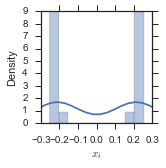

In [18]:
plt.figure(figsize=(2,2))
sns.distplot(np.array(barbell_mod_x), bins=10)
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.xlim(-0.3,0.3)
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_mod_laplacian_eigenvector_density.pdf',  bbox_inches = 'tight', pad_inches=0)

Coloring the vertices with respect to the sign of the associated entry in the eigenvalue, we find

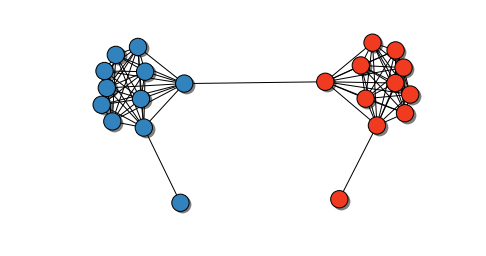

In [19]:
vertex_color = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in barbell_mod_x]
visualize_graph(barbell_mod, pos=pos_barbell_mod, colors=vertex_color, figsize=(6,3))
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_mod_clustered.pdf',  bbox_inches = 'tight', pad_inches=0)

Similarly, the "pure" Barbell graph will be just as easy to bisect:

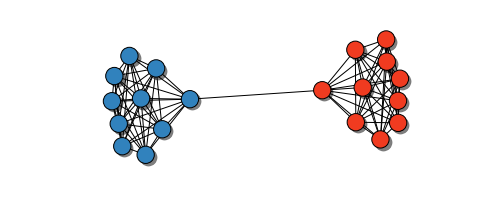

In [20]:
barbell_x = get_kth_eigenvector(barbell, matrix=nx.linalg.laplacian_matrix, k=1)
vertex_color = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in barbell_x]
visualize_graph(barbell, pos=pos_barbell, colors=vertex_color, figsize=(6,2.5))
# Uncomment to save to the figures folder
# plt.savefig('../figures/barbell_clustered.pdf',  bbox_inches = 'tight', pad_inches=0)

# Randomized graphs

The example above is somewhat contrived---large cliques seldom occur in graphs describing real datasets.
Often there will be many "missing edges" in a cluster.

We can represent this using the Erdos-Renyi (ER) graph ensemble and the planted partition model.


## Erdos-Renyi graphs

In an ER graph, an edge exists with probability $p$, independently from all other edges.

Naturally, `networkx` provides the facility to generate these graphs.

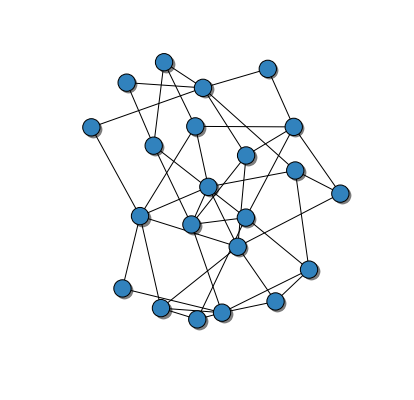

In [21]:
er = nx.generators.erdos_renyi_graph(n=22, p=0.2, seed=42)
er_pos = nx.layout.spring_layout(er)
visualize_graph(er, colors=[two_colors_palette[0]]*40, figsize=(5,5))

ER graphs are not very interesting because from the clustering point of view, because the neighborhood of every vertex is statistically equivalent, by construction.
That is, the best partitions do not stand out particularly.

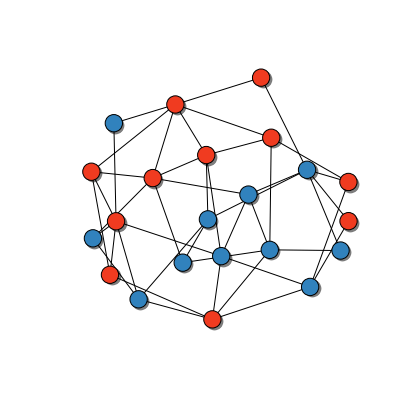

In [22]:
er_x = get_kth_eigenvector(er, matrix=nx.linalg.laplacian_matrix, k=1)
vertex_color = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in barbell_mod_x]
visualize_graph(er, colors=vertex_color, figsize=(5,5))

In fact, we could have seen that "right of the bat", by looking at the spectrum of the graph Laplacian $\mathbf{L}$.

In [23]:
er_spectrum = nx.linalg.laplacian_spectrum(er)

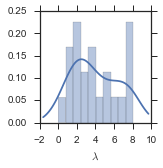

In [24]:
plt.figure(figsize=(2,2))
visualize_spectrum_density(er_spectrum, nbins=10)

Notice how the smallest eigenvalues are not well separated from the other eigenvalues.

In fact, if we want to be precise about these things, we can look at the gap between two eigenvalues (the "eigengap") and normalize this gap by the number of nodes in $G$, i.e. consider the series of gaps $\Delta_i(\mathbf{\Lambda})=(\lambda_{i+1}-\lambda_{i})/N$ defined over the ordered eigenvalues of $\mathbf{L}$.

Large gaps in the eigenvalue are known to reveal a good approximate clustering.
More precisely, if $\Delta_g$ is the *first* "large" gap, then there exists a "good" clustering in $g$ blocks.
For the sake of this tutorial, we will accept this fact and refrain proving bounds on the quality of the resulting clustering.

In [25]:
def get_eigen_gap(spectrum, N):
    return [(spectrum[i+1] - spectrum[i])/N for i in range(len(spectrum) - 1)]

In [26]:
barbell_spectrum_gap =  get_eigen_gap(barbell_mod_spectrum, N=barbell_mod.number_of_nodes())
er_spectrum_gap = get_eigen_gap(er_spectrum, N=er.number_of_nodes())

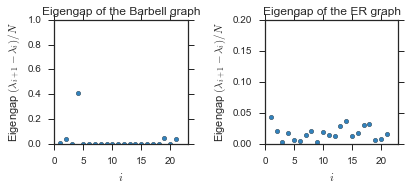

In [27]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.title('Eigengap of the Barbell graph')
plt.scatter(range(1, len(barbell_spectrum_gap)+1), barbell_spectrum_gap, c=two_colors_palette[0])
plt.xlabel("$i$")
plt.ylabel("Eigengap $(\lambda_{i+1}-\lambda_{i})/N$")
plt.xlim(0,23)
plt.ylim(0,1)
plt.subplot(122)
plt.title('Eigengap of the ER graph')
plt.scatter(range(1, len(er_spectrum_gap) + 1), er_spectrum_gap, c=two_colors_palette[0])
plt.xlabel("$i$")
plt.ylabel("Eigengap $(\lambda_{i+1}-\lambda_{i})/N$")
plt.ylim(0,0.2)
plt.xlim(0,23)
plt.tight_layout(pad=2)

The Barbell graph has two dominant eigengaps.
The first (and smallest) indicates the bisection identified below, and the second (and largest) indicates the partition which separates the graph in 4 blocks.
This partition assigns the vertices of degree one to their own block.

The ER graph, on the contrary, has no such eigengap: It has no good bisection, or multiway cut for that matter.

# Caveman graph: the eingengap

We will revisit the Eigengap more in detail using the caveman graph.

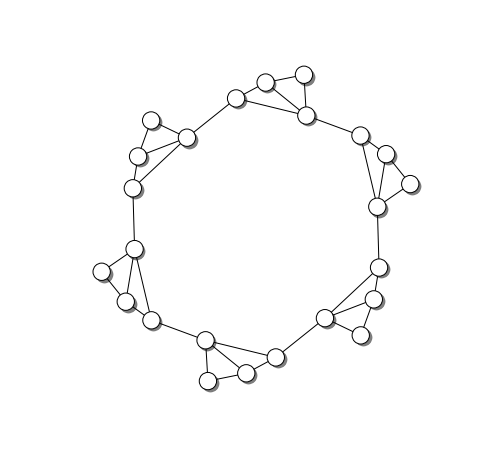

In [28]:
caveman = nx.generators.connected_caveman_graph(6,4)
caveman_pos = nx.spectral_layout(caveman)
caveman_pos = nx.layout.spring_layout(caveman, pos=caveman_pos,
                                      iterations=2)
visualize_graph(caveman, pos=caveman_pos, colors=['w']*32, figsize=(6,6))
# Uncomment to save to the figures folder
# plt.savefig('../figures/caveman_64.pdf',  bbox_inches = 'tight', pad_inches=0)

It consists of $l$ cliques of size $k$ connected in a circle.
The largest eigengap should obviously predict $l$.

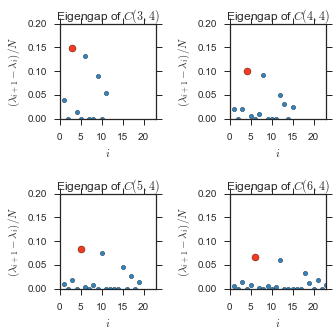

In [29]:
lrange = range(3,7)
plt.figure(figsize=(5,5))
for idx,l in enumerate(lrange):
    g = nx.generators.connected_caveman_graph(l,4)
    spectrum = nx.linalg.laplacian_spectrum(g)
    gap = get_eigen_gap(sorted(spectrum), N=g.number_of_nodes())
    plt.subplot(2,len(lrange)//2, idx + 1)
    plt.title('Eigengap of $C('+str(l)+',4)$')
    plt.scatter(range(1, len(gap) + 1), gap, c=two_colors_palette[0])
    plt.scatter(l, gap[l-1], c=two_colors_palette[1], s=50)
    plt.xlabel("$i$")
    plt.ylabel("$(\lambda_{i+1}-\lambda_{i})/N$")
    plt.ylim(0,0.2)
    plt.xlim(0,23)
    
plt.tight_layout(pad=2)
    
# Uncomment to save to the figures folder
# plt.savefig('../figures/caveman_eigengap.pdf',  bbox_inches = 'tight', pad_inches=0)

We see that the largest eigengap indeed corresponds to $l$, the number of cliques. 
There exists a number of almost as good partitions which *merge* two cliques---these are indicated by minor eigengaps.

## Planted partition model

The planted partition model is a simple generalization of Erdos Renyi graphs which allows for graphs graphs with a natural separation of the vertices in blocks.

Roughly, one generates a few ER graph of identical density $p_{in}$, and the connected the vertices of these graphs with probability $p_{out}<p_{in}$.

`networkx` also provides a function that generate these graphs out of the box.
Below we create a graph of 2 blocks of 20 nodes, with an internal density $p_{in}=0.4$ and external density $p_{out}=0.01$.


In [30]:
ppm = nx.generators.community.planted_partition_graph(2, 20, 0.4, 0.01)

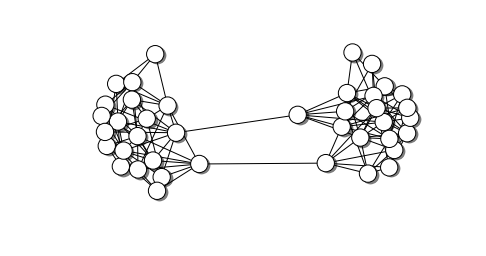

In [31]:
ppm_pos = nx.layout.spectral_layout(ppm)
ppm_pos = nx.layout.spring_layout(ppm, pos=ppm_pos)
visualize_graph(ppm, colors=['w']*40, pos=ppm_pos, figsize=(6,3))

# Uncomment to save to the figures folder
# plt.savefig('../figures/graph_ppm.pdf',  bbox_inches = 'tight', pad_inches=0)

Even if the natural blocks are not cliques anymore, and even if the two blocks are a little bit more coupled, it should be easy enough to find a partition.

In [32]:
ppm_spectrum = nx.linalg.laplacian_spectrum(ppm)
ppm_spectrum_gap = get_eigen_gap(ppm_spectrum, N=ppm.number_of_nodes())

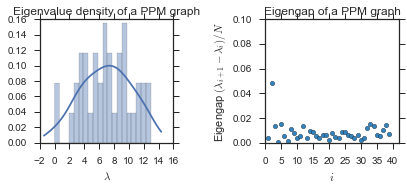

In [33]:
plt.figure(figsize=(6,3))

plt.subplot(121)
plt.title('Eigenvalue density of a PPM graph')
visualize_spectrum_density(ppm_spectrum, nbins=20)

plt.subplot(122)
plt.title('Eigengap of a PPM graph')
plt.scatter(range(1, len(ppm_spectrum_gap) + 1), ppm_spectrum_gap, c=two_colors_palette[0])
plt.xlabel("$i$")
plt.ylabel("Eigengap $(\lambda_{i+1}-\lambda_{i})/N$")
plt.ylim(0,0.1)
plt.xlim(0,42)
plt.tight_layout(pad=2)

There is a clear gap at $g=2$ and we may safely look for a bisection.

In [34]:
ppm_x = get_kth_eigenvector(ppm, matrix=nx.linalg.laplacian_matrix, k=1)

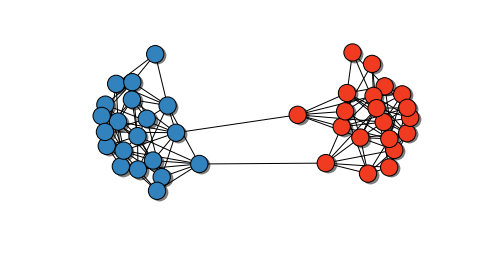

In [35]:
vertex_color = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in ppm_x]
visualize_graph(ppm, colors=vertex_color, pos=ppm_pos,  figsize=(6,3))

# Uncomment to save to the figures folder
# plt.savefig('../figures/graph_ppm_clustered.pdf',  bbox_inches = 'tight', pad_inches=0)

We can look the eigenvector and spectrum statistics to confirm that clustering was indeed, easy.

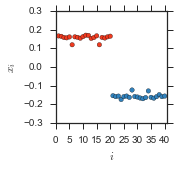

In [36]:
plt.figure(figsize=(2,2))
visualize_eigenvector(np.array(ppm_x), colors=None)
# Save to the figures folder
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_laplacian_eigenvector.pdf',  bbox_inches = 'tight', pad_inches=0)

([<matplotlib.axis.XTick at 0x7ff40394d710>,
 <a list of 5 Text xticklabel objects>)

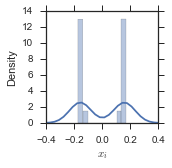

In [37]:
plt.figure(figsize=(2,2))
sns.distplot(np.array(ppm_x), bins=10)
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2, 0, 0.2, 0.4])
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_laplacian_eigenvector_density.pdf',  bbox_inches = 'tight', pad_inches=0)

Of course, as $|p_{in}-p_{out}|\to 0$, our ability to separate the cluster will vanish.

For instance

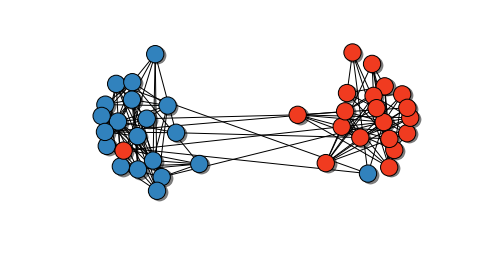

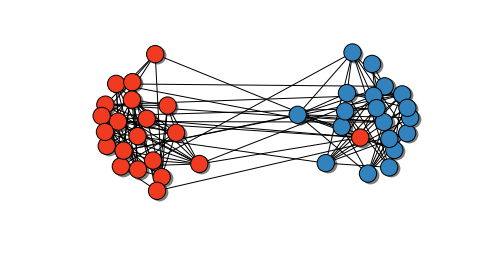

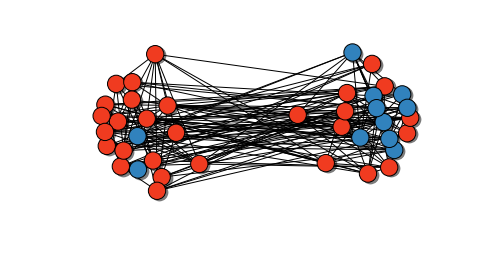

In [38]:
for (p_in, p_out) in [(0.3,0.01), (0.3, 0.05), (0.3, 0.2)]:
    g = nx.generators.community.planted_partition_graph(2, 20, p_in, p_out)
    x = get_kth_eigenvector(g, matrix=nx.linalg.laplacian_matrix, k=1)
    c = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in x]
    pos = nx.layout.spectral_layout(ppm)
    pos = nx.layout.spring_layout(ppm, pos=pos)
    visualize_graph(g, colors=c, figsize=(6,3), pos=pos)

As shown by the example above, when the externals connections are too strong, it becomes hard to bisect the graph with the spectral approach.

We look at the case $p_{in}=0.3,p_{out}=0.2$ more explicitly.


In [39]:
(p_in, p_out) = (0.3, 0.2)
hard_ppm = nx.generators.community.planted_partition_graph(2, 20, p_in, p_out)
hard_ppm_x = get_kth_eigenvector(hard_ppm, matrix=nx.linalg.laplacian_matrix, k=1)
hard_ppm_spectrum = nx.linalg.laplacian_spectrum(hard_ppm)

(0, 20)

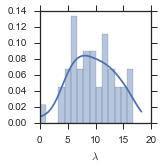

In [40]:
plt.figure(figsize=(2,2))
visualize_spectrum_density(hard_ppm_spectrum, nbins=15)
plt.xlim(0,20)
# Uncomment to save to the figures folder
# plt.savefig('../figures/hard_ppm_laplacian_spectrum.pdf',  bbox_inches = 'tight', pad_inches=0)

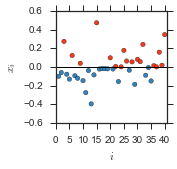

In [41]:
plt.figure(figsize=(2,2))
visualize_eigenvector(np.array(hard_ppm_x), colors=None)
plt.plot([0,42],[0,0], c='k', lw=1)
# Uncomment to save to the figures folder
# plt.savefig('../figures/hard_ppm_laplacian_eigenvector.pdf',  bbox_inches = 'tight', pad_inches=0)

([<matplotlib.axis.XTick at 0x7ff403b70978>,
 <a list of 5 Text xticklabel objects>)

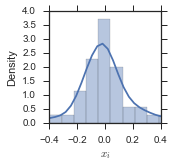

In [42]:
plt.figure(figsize=(2,2))
sns.distplot(np.array(hard_ppm_x), bins=10)
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2, 0, 0.2, 0.4])
# Uncomment to save to the figures folder
# plt.savefig('../figures/hard_ppm_laplacian_eigenvector_density.pdf',  bbox_inches = 'tight', pad_inches=0)

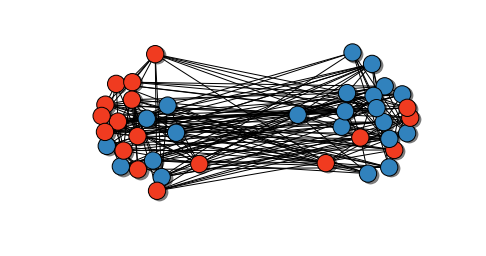

In [43]:
c = [two_colors_palette[0] if x_i < 0 else two_colors_palette[1] for x_i in hard_ppm_x]
visualize_graph(hard_ppm, colors=c, figsize=(6,3), pos=ppm_pos)
# Uncomment to save to the figures folder
# plt.savefig('../figures/graph_hard_ppm_clustered.pdf',  bbox_inches = 'tight', pad_inches=0)

# Three-way partition

The method generalizes to higher dimensions.

To test these ideas we will look at graphs with many communities, e.g. planted partition graphs of 3 communities.

In [44]:
(p_in, p_out) = (0.4, 0.02)
ppm_3_blocks = nx.generators.planted_partition_graph(3, 20, p_in, p_out)

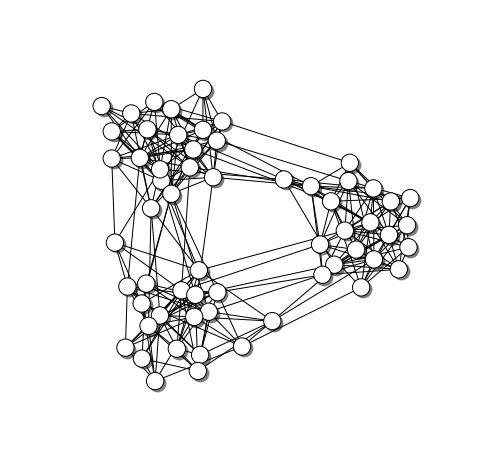

In [45]:
ppm_3_blocks_pos = nx.layout.spectral_layout(ppm_3_blocks)
ppm_3_blocks_pos = nx.layout.spring_layout(ppm_3_blocks, pos=ppm_3_blocks_pos)
visualize_graph(ppm_3_blocks, colors=['w']*60, figsize=(6,6), pos=ppm_3_blocks_pos)
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_3_blocks_blank.pdf',  bbox_inches = 'tight', pad_inches=0)

The clustering method is identical, but we now look at 2 eigenvectors rather than one (we always need $g-1$ eigenvector where $g$ is the number of blocks)

In [46]:
ppm_3_blocks_spectrum = nx.linalg.laplacian_spectrum(ppm_3_blocks)

(0, 17)

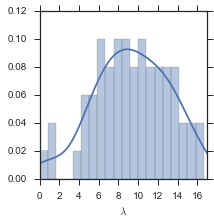

In [47]:
plt.figure(figsize=(3,3))
visualize_spectrum_density(ppm_3_blocks_spectrum, nbins=20)
plt.xlim(0,17)
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_3_blocks_laplacian_spectrum.pdf',  bbox_inches = 'tight', pad_inches=0)

In [48]:
ppm_3_blocks_x1 = get_kth_eigenvector(ppm_3_blocks, matrix=nx.linalg.laplacian_matrix, k=1)
ppm_3_blocks_x2 = get_kth_eigenvector(ppm_3_blocks, matrix=nx.linalg.laplacian_matrix, k=2)

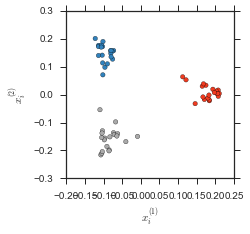

In [49]:
plt.figure(figsize=(3,3))
plt.scatter(np.array(ppm_3_blocks_x1), np.array(ppm_3_blocks_x2),
            c=get_two_colors(40) + ["#aaaaaa"]*20)
plt.xlabel('$x_i^{(1)}$')
plt.ylabel('$x_i^{(2)}$')
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_3_blocks_eigevec.pdf',  bbox_inches = 'tight', pad_inches=0)

We will use `sklearn` to cluster these values with the `kmeans` algorithm.

In [50]:
import sklearn.cluster

We first need to convert the eigenvalues to the matrix format.

In [51]:
x = np.concatenate((np.matrix(ppm_3_blocks_x1), np.matrix(ppm_3_blocks_x2)), axis=1 )

`sklearn` then does all the heavy lifting and clusters the point for us.

In [52]:
clustering = sklearn.cluster.k_means(x, 3)

The `clutering` object contains a lot of information about the result of KMeans

In [53]:
clustering

(array([[ 0.17951025,  0.00846109],
        [-0.09616291,  0.14873823],
        [-0.08334734, -0.15719932]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
 0.093514153249348336)

The property that will be of interest to us it the second element of the tuple: the label of the vertices.

For the record, the first element of the tuple is the centroids of the clusters in $\mathbb{R}^2$, and the third element is the sum of the distance between the elements of clusters and their respective centers---a measure of quality.

For more information, see [the documentation of sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

We can check that we correctly clustered by coloring the node with respect to their block.

In [54]:
colors_mapping = {0: two_colors_palette[0],
                  1: two_colors_palette[1],
                  2: "#aaaaaa"}
color_vertices = [colors_mapping[clustering[1][v]] for v in ppm_3_blocks.nodes()]

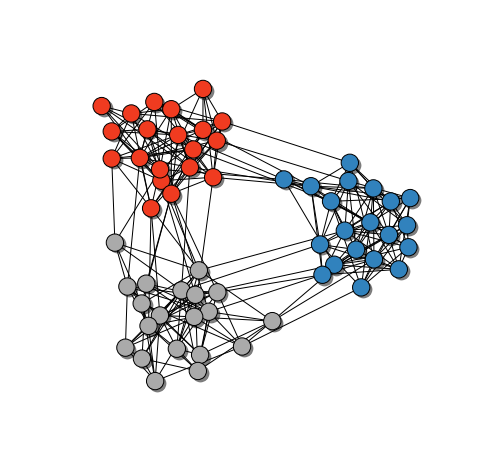

In [55]:
visualize_graph(ppm_3_blocks, colors=color_vertices,  figsize=(6,6), pos=ppm_3_blocks_pos)
# Uncomment to save to the figures folder
# plt.savefig('../figures/ppm_3_blocks_clustered.pdf',  bbox_inches = 'tight', pad_inches=0)

Note that the eigengap predicts the partition in 3 blocks again.

In [56]:
ppm_3_blocks_gap = get_eigen_gap(ppm_3_blocks_spectrum, N=ppm_3_blocks.number_of_nodes())

(0, 0.05)

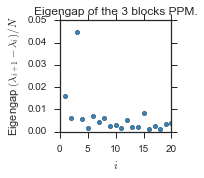

In [57]:
plt.figure(figsize=(2,2))
plt.title('Eigengap of the 3 blocks PPM.')
plt.scatter(range(1, len(ppm_3_blocks_gap)+1), ppm_3_blocks_gap, c=two_colors_palette[0])
plt.xlabel("$i$")
plt.ylabel("Eigengap $(\lambda_{i+1}-\lambda_{i})/N$")
plt.xlim(0,20)
plt.ylim(0,0.05)

# Zachary's Karate Club

In [64]:
zachary = nx.read_gml('../datasets/karate.gml')

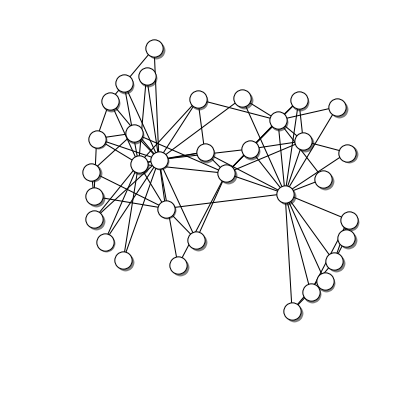

In [68]:
zachary_pos = nx.spring_layout(zachary)
visualize_graph(zachary, colors='w', pos=zachary_pos, figsize=(5,5))
# Uncomment to save to the figures folder
# plt.savefig('../figures/zachary_blank.pdf',  bbox_inches = 'tight', pad_inches=0)

In [69]:
zachary_spectrum = nx.linalg.laplacian_spectrum(zachary)
zachary_gaps = get_eigen_gap(zachary_spectrum, zachary.number_of_nodes())

(0, 10)

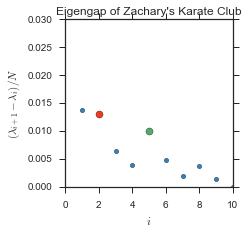

In [156]:
plt.figure(figsize=(3,3))
plt.title("Eigengap of Zachary's Karate Club")
plt.scatter(range(1, len(zachary_gaps) + 1), zachary_gaps, c=two_colors_palette[0])
plt.scatter(2, zachary_gaps[1], c=two_colors_palette[1], s=50)
plt.scatter(5, zachary_gaps[4], c=sns.color_palette()[1], s=50)
plt.xlabel("$i$")
plt.ylabel("$(\lambda_{i+1}-\lambda_{i})/N$")
plt.ylim(0,0.03)
plt.xlim(0,10)

# Uncomment to save to the figures folder
# plt.savefig('../figures/zachary_gaps.pdf',  bbox_inches = 'tight', pad_inches=0)

In [145]:
X = get_kth_eigenvector(zachary, nx.linalg.laplacian_matrix, k=1)
zachary_blocks = sklearn.cluster.KMeans(n_clusters=2).fit_predict(X)

In [139]:
colors_mapping = {0: sns.color_palette()[0],
                  1: sns.color_palette()[1],
                  2: sns.color_palette()[2],
                  3: sns.color_palette()[3]}
color_vertices = [colors_mapping[clustering[1][v]] for v in ppm_3_blocks.nodes()]

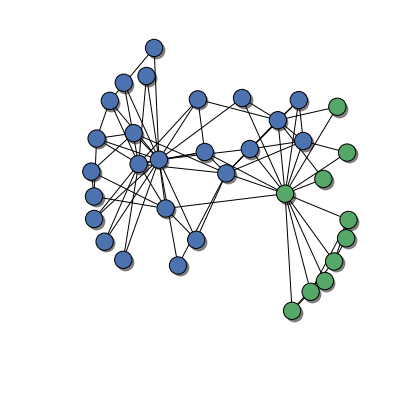

In [152]:
visualize_graph(zachary, pos=zachary_pos, colors=[colors_mapping[i] for i in zachary_blocks], figsize=(5,5))
# Uncomment to save to the figures folder
# plt.savefig('../figures/zachary_2blocks.pdf',  bbox_inches = 'tight', pad_inches=0)

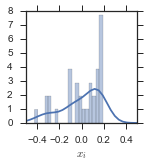

In [158]:
plt.figure(figsize=(2,2))
visualize_spectrum_density(np.array(X), nbins=20)
plt.xlim(-0.5,0.5)
plt.xlabel("$x_i$")

# Uncomment to save to the figures folder
# plt.savefig('../figures/zachary_2blocks_x.pdf',  bbox_inches = 'tight', pad_inches=0)

In [159]:
X = [get_kth_eigenvector(zachary, nx.linalg.laplacian_matrix, k=i) for i in [1,2,3]]
X = np.concatenate(X, axis=1)
zachary_blocks = sklearn.cluster.KMeans(n_clusters=4).fit_predict(X)

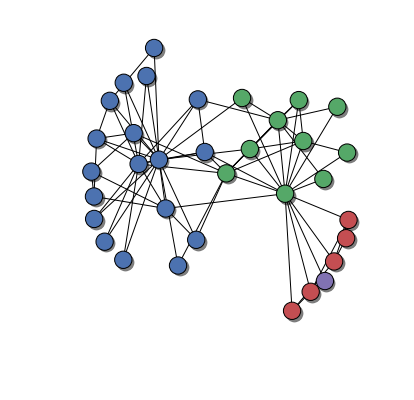

In [162]:
visualize_graph(zachary, pos=zachary_pos, colors=[colors_mapping[i] for i in zachary_blocks], figsize=(5,5))
# Uncomment to save to the figures folder
# plt.savefig('../figures/zachary_4blocks.pdf',  bbox_inches = 'tight', pad_inches=0)

# Graph coloring

The optimization framework is general enough to handle graph coloring.

We here use the adjacency matrix and its lowest eigenvector to find the coloring.

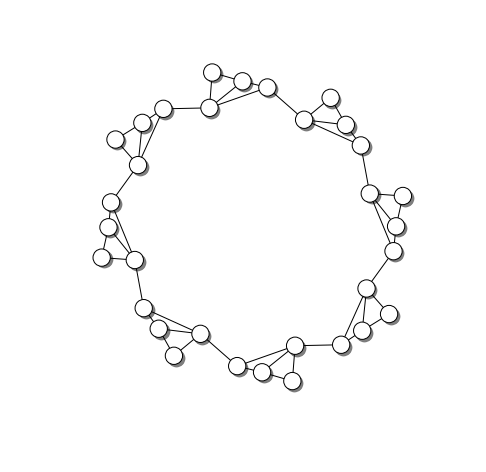

In [58]:
caveman = nx.generators.connected_caveman_graph(8,4)
caveman_pos = nx.spectral_layout(caveman)
# caveman_pos = nx.layout.random_layout(caveman)
caveman_pos = nx.layout.spring_layout(caveman, pos=caveman_pos,
                                      iterations=2)
visualize_graph(caveman, pos=caveman_pos, colors=['w']*32, figsize=(6,6))

This does not show up nicely here, but each set of 4 vertices is a clique.

In [59]:
X = [get_kth_eigenvector(caveman, k=i) for i in range(1)]
X = np.concatenate(X, axis=1)

In [60]:
coloring = sklearn.cluster.KMeans(n_clusters=4).fit_predict(X)

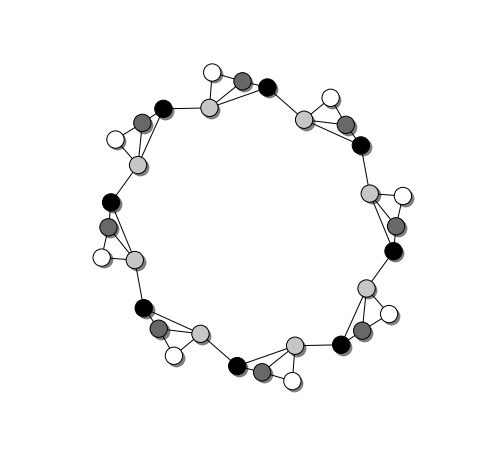

In [61]:
visualize_graph(caveman, pos=caveman_pos, colors=coloring, figsize=(6,6))

# Uncomment to save to the figures folder
# plt.savefig('../figures/caveman_coloring.pdf',  bbox_inches = 'tight', pad_inches=0)
